## 기본 베이지 DNN

In [71]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE
import math
import matplotlib.pyplot as plt
%matplotlib inline



In [72]:
%matplotlib inline

In [73]:
df=pd.read_excel('./optimal_data3_1/'+'Continous_2weeks_7day_1term.xlsx')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_scaler,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (57200, 6) (57200,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (150168, 6) (150168,)
SMOTE 적용 전 레이블 값 분포: 
 0    50056
1     4698
2     2446
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    50056
1    50056
2    50056
Name: 8, dtype: int64


In [74]:
train_dataset.element_spec


AttributeError: 'TensorDataset' object has no attribute 'element_spec'

In [ ]:
type(train_dataset)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_train_over, y_train_over, test_size=0.20, stratify=y_train_over)

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.to_numpy())
y_test = torch.LongTensor(y_test.to_numpy())

train_dataset = TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16,shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16,shuffle=False)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [76]:
train_dataset[0][1]

tensor(1)

In [77]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [78]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)
        lbl = lbl.squeeze()
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [79]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            lbl = lbl.squeeze()

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [80]:
def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        print("data_loader",data_loader)
        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)
            lbl = lbl.squeeze()
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

In [81]:
# 최대 Epoch을 지정합니다.
num_epochs = 1
min_loss = 9999999999999
loss_list=[]
acc_list=[]
# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)
    
    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
            print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
            min_loss = val_loss
            torch.save(model.state_dict(), 'DNNModel.pth')

    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
    loss_list.append(train_loss)
    acc_list.append(train_acc)
## 저장한 가중치 로드 후 검증 성능 측정

# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load('DNNModel.pth'))

# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc, pred_list = model_test(model, test_dataloader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')


100%|█████████████████████████████████████████████████████████████████████████████| 7509/7509 [00:13<00:00, 550.64it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.72749. Saving Model!
epoch 01, loss: 0.85049, acc: 0.58885, val_loss: 0.72749, val_accuracy: 0.67727
data_loader <torch.utils.data.dataloader.DataLoader object at 0x0000019D5CFE6550>
evaluation loss: 0.72749, evaluation accuracy: 0.67727


In [82]:
pred_list

[[0, 2, 2, 1, 2, 1, 0, 2, 1, 2, 1, 0, 2, 0, 1, 1],
 [0, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 2],
 [2, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 2, 1, 2, 0, 2],
 [2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 1, 1, 0, 2, 1, 1],
 [0, 0, 0, 0, 1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2],
 [2, 2, 2, 1, 2, 0, 1, 1, 2, 1, 1, 2, 0, 2, 2, 2],
 [1, 2, 2, 1, 0, 2, 2, 1, 2, 1, 1, 2, 1, 0, 0, 0],
 [1, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 1, 0, 2, 2, 2],
 [2, 2, 1, 2, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 0],
 [1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 1, 0, 2, 2],
 [1, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 1, 2, 1, 2, 0],
 [2, 0, 1, 2, 2, 2, 0, 0, 0, 2, 1, 2, 1, 0, 2, 2],
 [2, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 2, 1, 0, 1, 1],
 [0, 2, 0, 1, 2, 2, 2, 1, 2, 0, 2, 1, 1, 2, 2, 0],
 [1, 2, 0, 2, 1, 0, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2],
 [2, 1, 2, 0, 2, 0, 1, 0, 1, 1, 1, 1, 2, 0, 2, 0],
 [2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
 [2, 0, 2, 0, 2, 0, 0, 2, 1, 1, 2, 2, 0, 2, 1, 1],
 [1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 0, 2, 0, 2, 0, 2],
 [0, 1, 2, 2, 2, 1, 0, 2, 2, 2,

In [83]:
listarray=[]
for i in pred_list:
    for j in i:
        listarray.append(j)

In [84]:
listarray

[0,
 2,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 1,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 0,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 2,
 0,
 2,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 1,
 2,
 2,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 1,


## 그래프 그리기

In [85]:
train_loss_list = torch.tensor(loss_list)
train_acc_list = torch.tensor(acc_list)

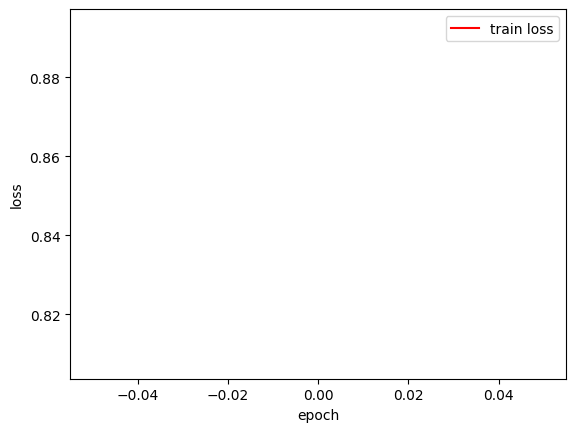

In [86]:

plt.plot(train_loss_list, label='train loss',color='red')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

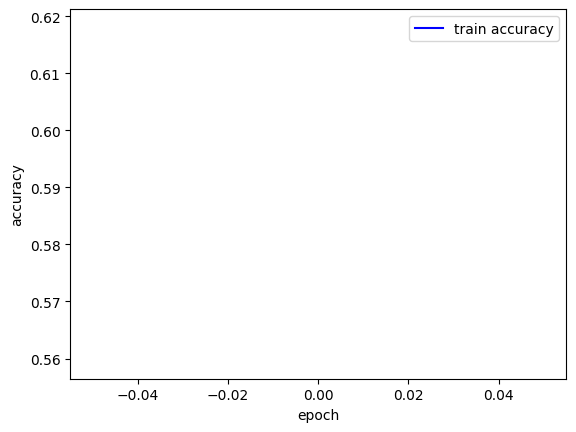

In [87]:
plt.plot(train_acc_list, label='train accuracy',color='blue')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Confusion matrix

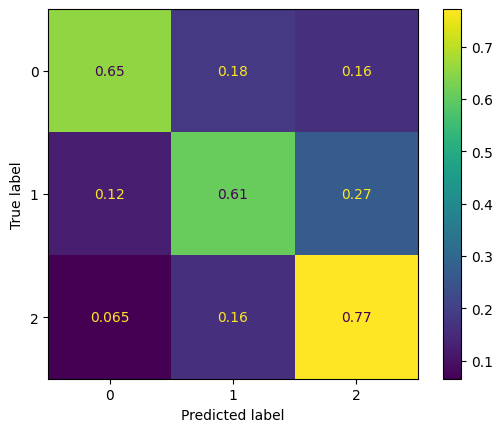

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, listarray)

cm = confusion_matrix(y_test, listarray, labels=[0,1,2],normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
disp.plot()
plt.show()

In [89]:
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
f1 = f1_score(y_test,listarray,pos_label='positive', average='micro')
accuracy_score=accuracy_score(y_test, listarray) * 100
print(f1)
print("정확도: {}".format(accuracy_score))

0.6772657654658054
정확도: 67.72657654658055


C:\Users\jaemin\Anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [90]:

print('SMOTE 적용 후 테스트용 피처/레이블 데이터 세트: ', X_test.shape, y_test.shape)
# print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_test).value_counts())

SMOTE 적용 후 테스트용 피처/레이블 데이터 세트:  torch.Size([30034, 6]) torch.Size([30034])
SMOTE 적용 후 레이블 값 분포: 
 0    10012
2    10011
1    10011
dtype: int64


In [91]:
from collections import Counter
result = Counter(listarray)

In [92]:
result

Counter({0: 8440, 2: 12065, 1: 9529})

### AUC

In [93]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [94]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# make sample data
n_classes = 3


print("roc_auc_score: ", multiclass_roc_auc_score(y_test, listarray))

roc_auc_score:  0.7579502678020361
